# Imports

In [1]:
import matplotlib
from google.colab import runtime

# Por defecto tiene matplotlib: 3.2.2
print('matplotlib: {}'.format(matplotlib.__version__))

if matplotlib.__version__ == '3.2.2':
    # Se necesita una versión > 3.5.1 que soporte float16 para pintar kanji
    !pip install -U matplotlib

    print('Stopping RUNTIME! Please run again.')
    quit()
    # https://twitter.com/GoogleColab/status/1569389018311426051

matplotlib: 3.7.0


In [2]:
# track time of each cell
!pip install ipython-autotime
%load_ext autotime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
time: 369 µs (started: 2023-02-18 21:49:15 +00:00)


In [3]:
from pprint import pprint

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow, subplots, show
import PIL as pil
import skimage.transform
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    classification_report,
    confusion_matrix
)
#import tensorflow as tf
from tensorflow import keras
from keras.layers import (
    Conv2D, MaxPool2D, Flatten, Dense, Dropout, Input, Concatenate
)
from keras.models import Model
from tensorflow import keras
from keras.utils import to_categorical
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from google.colab import drive

time: 3.44 s (started: 2023-02-18 21:49:15 +00:00)


In [4]:
CHANNEL = 1
DATA_REPR = 'float32' # Antes era 'uint8'
NUM_CLASSES = 881
ETL_DATASET = 'etl_8G'
DNN_NAME = 'VGG19'
FC_LAYER = 4096

USE_DATA_AUG = 'sin_DA' # o también con_DA
TYPE_IMG = 'regular' # o también regular

TFM_PATH = '/content/gdrive/MyDrive/Master_IA/TFM/'
ROOT_PATH = TFM_PATH + 'datasets/'+ ETL_DATASET +'/uint32/imgs_{}/splits/'+ TYPE_IMG +'/'


print('versión Keras:', keras.__version__)

versión Keras: 2.11.0
time: 1.15 ms (started: 2023-02-18 21:49:19 +00:00)


In [5]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive
time: 18.3 s (started: 2023-02-18 21:49:19 +00:00)


# Funciones

In [7]:
def load_images_for_training(DATA_REPR, PATH, TYPE_IMG):
    '''
    Load images for training and validation with their labels

    Args:

    - DATA_REPR: Representation of numpy data. Ex: uint8, float32
    - ROOT_PATH: Path in Google Drive where imgs and labels are stored
    - TYPE_IMG: regular o inverted

    Output:
    - np arrays for training and validation images
    '''

    if TYPE_IMG == 'regular':
        train_name_img = 'train_imgs_8G.npz'
        train_name_labels = 'train_labels_8G.npz'
        val_name_img = 'val_imgs_8G.npz'
        val_name_labels = 'val_labels_8G.npz'
    elif TYPE_IMG == 'inverted':
        train_name_img = 'train_inv_imgs_8G.npz'
        train_name_labels = 'train_inv_labels_8G.npz'
        val_name_img = 'val_inv_imgs_8G.npz'
        val_name_labels = 'val_inv_labels_8G.npz'

    train_images = np.load(PATH+train_name_img)['arr_0']
    train_labels = np.load(PATH+train_name_labels)['arr_0'].astype(DATA_REPR)

    val_images = np.load(PATH+val_name_img)['arr_0']
    val_labels = np.load(PATH+val_name_labels)['arr_0'].astype(DATA_REPR)

    return train_images, train_labels, val_images, val_labels


def load_test_images(DATA_REPR, PATH, TYPE_IMG):
    '''
    Load images for training and validation with their labels

    Args:

    - DATA_REPR: Representation of numpy data. Ex: uint8, float32
    - ROOT_PATH: Path in Google Drive where imgs and labels are stored

    Output:
    - np arrays for testing images
    '''

    if TYPE_IMG == 'regular':
        test_name_img = 'test_imgs_8G.npz'
        test_name_labels = 'test_labels_8G.npz'
    elif TYPE_IMG == 'inverted':
        test_name_img = 'test_inv_imgs_8G.npz'
        test_name_labels = 'test_inv_labels_8G.npz'

    test_images = np.load(PATH+test_name_img)['arr_0']
    test_labels = np.load(PATH+test_name_labels)['arr_0'].astype(DATA_REPR)

    return test_images, test_labels


def avg_wts(weights):
    '''
    Function that calculates average of weights along the channel axis
    '''

    #Find mean along the channel axis (second to last axis)
    average_weights = np.mean(
        weights, axis=-2).reshape(weights[:,:,-1:,:].shape
    )  
    return(average_weights)


def configure_weights_model(HEIGHT_SHAPE , WIDTH_SHAPE, CHANNEL):
    vgg_model = keras.applications.VGG19(
        include_top=False, 
        weights='imagenet'
    )

    # Get the dictionary of config for vgg19
    vgg_config = vgg_model.get_config()


    vgg_config["layers"][0]["config"]["batch_input_shape"] = (
        None, HEIGHT_SHAPE , WIDTH_SHAPE, CHANNEL
    )

    # Create new model with the updated configuration
    vgg_updated = Model.from_config(vgg_config)

    # Get the configuration for the updated model and extract layer names. 
    # We will use these names to copy over weights from the original model. 
    vgg_updated_config = vgg_updated.get_config()
    vgg_updated_layer_names = [vgg_updated_config['layers'][x]['name'] for x in range(len(vgg_updated_config['layers']))]

    # Name of the first convolutional layer.
    # Remember that this is the only layer with new additional weights. 
    # All other layers will have same weights as the original model. 
    first_conv_name = vgg_updated_layer_names[1]

    # Update weights for all layers. 
    # And for the first conv layer replace weights with average of all 3 channels. 
    for layer in vgg_model.layers:
        if layer.name in vgg_updated_layer_names:
         

            if layer.get_weights() != []:
                target_layer = vgg_updated.get_layer(layer.name)
        
                if layer.name in first_conv_name:    #For the first convolutionl layer
                    weights = layer.get_weights()[0]
                    biases  = layer.get_weights()[1]
              
                    weights_single_channel = avg_wts(weights)
                                                        
                    target_layer.set_weights([weights_single_channel, biases])  #Now set weights for the first conv. layer
                    target_layer.trainable = False   #You can make this trainable if you want. 
        
                else:
                    target_layer.set_weights(layer.get_weights())   #Set weights to all other layers. 
                    target_layer.trainable = False  #You can make this trainable if you want. 

    return vgg_updated


def create_custom_model(NUM_CLASSES, FC_LAYER):

    last_layer = vgg_updated.layers[-1].output

    x = Flatten(name='flatten', input_shape=vgg_updated.output_shape[1:])(last_layer)
    x = Dense(FC_LAYER, activation='relu', name='fc1')(x)
    x = Dense(FC_LAYER, activation='relu', name='fc2')(x)
    out = Dense(NUM_CLASSES, activation='softmax', name='predictions')(x) # activation relu??
    custom_model = Model(vgg_updated.inputs, out)

    for layer in custom_model.layers[:-3]: # Hasta aquí llega hasta flatten
        layer.trainable = False

    return custom_model


def train_model(custom_model, train_images, train_labels, val_images, val_labels):

    callback = EarlyStopping(
        monitor='val_sparse_categorical_accuracy',
        patience=5,
        verbose=1
    )

    custom_model.compile(
        loss="sparse_categorical_crossentropy",
        optimizer=Adam(learning_rate=0.0001),
        metrics=["sparse_categorical_accuracy"]
    )

    history = custom_model.fit(
        train_images,
        train_labels,
        validation_data=(val_images, val_labels),
        epochs= 50, # en 2022 usé 20 epochs
        callbacks = [callback],
        # verbose = 1,
        # batch_size=32
    )

    print('--- Iterations ended ---')
    print()
    print()

    return history


def show_metrics(custom_model, test_images, test_labels):
    test_loss, test_accuracy = custom_model.evaluate(test_images, test_labels)
    y_pred = np.argmax(custom_model.predict(test_images), axis=1)

    print("*********************************************************************************************************************************")
    print()
    print("- Test Accuracy:", test_accuracy)
    print("- Test Loss:", test_loss)
    print("- time:")
    print("- F1 score:", f1_score(test_labels, y_pred, average='weighted'))
    print("- Precision score:", precision_score(test_labels, y_pred, average='weighted'))
    print("- Recall: ", recall_score(test_labels, y_pred, average='weighted'))
    print("- Epoch: ")
    print("*********************************************************************************************************************************")


def plot_loss(history):
    pd.DataFrame(history.history).plot(figsize=(7,5))
    plt.grid(True)
    plt.gca().set_ylim(0,2) # usualmente 0,5
    plt.show()


def show_history(history):
    '''Recuperar una lista de resultados de la lista de datos de los conjuntos 
    de entrenamiento y pruebas para cada epoch de entrenamiento.
    '''

    acc = history.history['sparse_categorical_accuracy']
    val_acc = history.history['val_sparse_categorical_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    #------------------------------------------------
    # Imprimir la precisión del entrenamiento y validación por epoch
    #------------------------------------------------
    plt.plot(epochs, acc, 'bo', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Precisión de entrenamiento y validación')
    plt.legend()
    plt.grid()
    plt.figure()

    #------------------------------------------------
    # Imprimir la perdida de entrenamiento y validación por epoch
    #------------------------------------------------
    plt.plot(epochs, loss, 'bo', label='Training Loss')
    plt.plot(epochs, val_loss, 'b', label='Validation Loss')
    plt.title('Perdida de entrenamiento y validación')
    plt.legend()
    plt.grid()
    plt.show()


def save_model(SIZE, TFM_PATH, custom_model, TYPE_IMG, USE_DATA_AUG, DNN_NAME, FC_LAYER):
    '''Guardar el modelo en disco duro
    
    Args:
        - SIZE: 64, 96, 112 ó 127
        - TFM_PATH = Ruta en drive a la carpeta del TFM
        - custom_model: Modelo de Deep Learning
        - TYPE_IMG: regular o inverted
        - USE_DATA_AUG= sin_DA o con_DA
        - DNN_NAME= Deep Neural Network's name like VGG19 or DenseNet121
        - FC_LAYER: Number of Dense Layer. In this case is 4096
    '''

    MODEL_NAME = f'model_{DNN_NAME.lower()}_etl8_imgs{SIZE}_' + TYPE_IMG +'.h5'
    WEIGHTS_PATH = TFM_PATH + 'notebooks/arqs_2023/' \
                + DNN_NAME + f'/weights_{DNN_NAME.lower()}/' \
                + USE_DATA_AUG +'/'+ TYPE_IMG + f'/{FC_LAYER}/'  + MODEL_NAME

    custom_model.save(WEIGHTS_PATH) # lo guarda es en el notebook

    print(f'------ Model Saved in {WEIGHTS_PATH}-------')


time: 8.82 ms (started: 2023-02-18 21:50:45 +00:00)


# Imgs 64x64

- Test Accuracy: 0.8167653679847717
- Test Loss: 0.7942817211151123
- time: 12min 57s
- F1 score: 0.8170823996215527
- Precision score: 0.8414299885049258
- Recall:  0.8167653694303441
- Epoch: 33/50

## Cargar la imágenes

In [ ]:
SIZE = 64  # integer number. Ex: 64, 96, 112 or 127
WIDTH_SHAPE = SIZE
HEIGHT_SHAPE = SIZE
PATH = ROOT_PATH.format(SIZE)

time: 566 µs (started: 2023-02-14 15:43:30 +00:00)


In [ ]:
train_images, train_labels, val_images, val_labels = load_images_for_training(DATA_REPR, PATH, TYPE_IMG)

time: 8.89 s (started: 2023-02-14 15:43:30 +00:00)


In [ ]:
print('- train images:', train_images.shape, 'and labels:', train_labels.shape)
print()
print('- val images:', val_images.shape, 'and labels:', val_labels.shape)
print()

- train images: (106380, 64, 64, 1) and labels: (106380,)

- val images: (21276, 64, 64, 1) and labels: (21276,)

time: 1.05 ms (started: 2023-02-14 15:43:39 +00:00)


## Preparar el modelo

In [ ]:
vgg_updated = configure_weights_model(HEIGHT_SHAPE , WIDTH_SHAPE, CHANNEL)

80134624/80134624 [==============================] - 0s 0us/step
time: 4.68 s (started: 2023-02-14 15:43:39 +00:00)


In [ ]:
custom_model = create_custom_model(NUM_CLASSES, FC_LAYER)

time: 48.7 ms (started: 2023-02-14 15:43:44 +00:00)


In [ ]:
print(custom_model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 1)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        640       
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0     

## Entrenar modelo

In [ ]:
history = train_model(custom_model, train_images, train_labels, val_images, val_labels)

Epoch 1/50
3325/3325 [==============================] - 33s 7ms/step - loss: 4.6779 - sparse_categorical_accuracy: 0.1156 - val_loss: 3.0937 - val_sparse_categorical_accuracy: 0.2837
Epoch 2/50
3325/3325 [==============================] - 23s 7ms/step - loss: 2.4506 - sparse_categorical_accuracy: 0.3984 - val_loss: 2.0428 - val_sparse_categorical_accuracy: 0.4884
Epoch 3/50
3325/3325 [==============================] - 23s 7ms/step - loss: 1.7708 - sparse_categorical_accuracy: 0.5412 - val_loss: 1.6237 - val_sparse_categorical_accuracy: 0.5807
Epoch 4/50
3325/3325 [==============================] - 23s 7ms/step - loss: 1.4169 - sparse_categorical_accuracy: 0.6224 - val_loss: 1.4099 - val_sparse_categorical_accuracy: 0.6283
Epoch 5/50
3325/3325 [==============================] - 23s 7ms/step - loss: 1.1847 - sparse_categorical_accuracy: 0.6776 - val_loss: 1.2509 - val_sparse_categorical_accuracy: 0.6633
Epoch 6/50
3325/3325 [==============================] - 23s 7ms/step - loss: 1.0283 -

In [ ]:
test_images, test_labels = load_test_images(DATA_REPR, PATH, TYPE_IMG)

time: 1.31 s (started: 2023-02-14 15:56:42 +00:00)


In [ ]:
show_metrics(custom_model, test_images, test_labels)

444/444 [==============================] - 2s 4ms/step
*********************************************************************************************************************************

- Test Accuracy: 0.8167653679847717
- Test Loss: 0.7942817211151123
- time:
- F1 score: 0.8170823996215527
- Precision score: 0.8414299885049258
- Recall:  0.8167653694303441
- Epoch: 
*********************************************************************************************************************************
time: 5.37 s (started: 2023-02-14 15:56:43 +00:00)


## Graficando

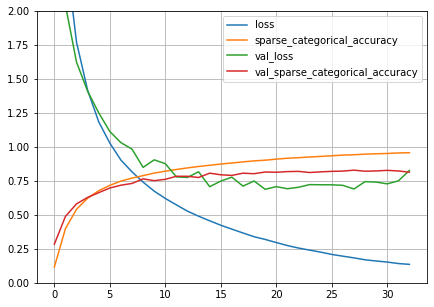

time: 266 ms (started: 2023-02-14 15:56:49 +00:00)


In [ ]:
plot_loss(history)

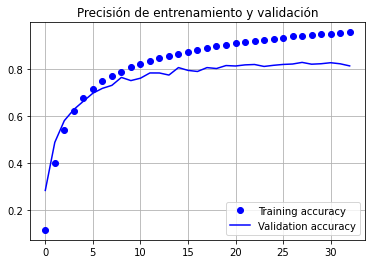

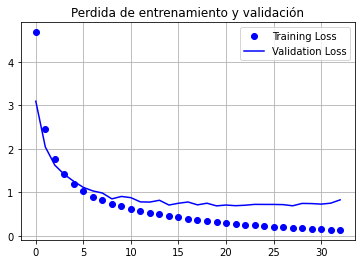

time: 365 ms (started: 2023-02-14 15:56:49 +00:00)


In [ ]:
show_history(history)

In [ ]:
save_model(SIZE, TFM_PATH, custom_model, TYPE_IMG, USE_DATA_AUG, DNN_NAME, FC_LAYER)

------ Model Saved -------
time: 3.41 s (started: 2023-02-14 15:56:49 +00:00)


# Imgs 96x96

- Test Accuracy: 0.8957275748252869
- Test Loss: 0.5082585215568542
- time: 21min 28s
- F1 score: 0.8962560017953719
- Precision score: 0.9093433666082814
- Recall:  0.8957275803722504
- Epoch: 41/50

## Cargar las imágenes

In [8]:
SIZE = 96  # integer number. Ex: 64, 96, 112 or 127
WIDTH_SHAPE = SIZE
HEIGHT_SHAPE = SIZE
PATH = ROOT_PATH.format(SIZE)

time: 712 µs (started: 2023-02-18 21:50:58 +00:00)


In [9]:
train_images, train_labels, val_images, val_labels = load_images_for_training(DATA_REPR, PATH, TYPE_IMG)

time: 15.3 s (started: 2023-02-18 21:50:58 +00:00)


In [10]:
print('- train images:', train_images.shape, 'and labels:', train_labels.shape)
print()
print('- val images:', val_images.shape, 'and labels:', val_labels.shape)
print()

- train images: (106380, 96, 96, 1) and labels: (106380,)

- val images: (21276, 96, 96, 1) and labels: (21276,)

time: 955 µs (started: 2023-02-18 21:51:14 +00:00)


## Preparar el modelo

In [11]:
vgg_updated = configure_weights_model(HEIGHT_SHAPE , WIDTH_SHAPE, CHANNEL)

80134624/80134624 [==============================] - 0s 0us/step
time: 4.82 s (started: 2023-02-18 21:51:14 +00:00)


In [12]:
custom_model = create_custom_model(NUM_CLASSES, FC_LAYER)

time: 48.6 ms (started: 2023-02-18 21:51:18 +00:00)


In [13]:
print(custom_model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 96, 96, 1)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 96, 96, 64)        640       
                                                                 
 block1_conv2 (Conv2D)       (None, 96, 96, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 48, 48, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 48, 48, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 48, 48, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 24, 24, 128)       0     

## Entrenar modelo

In [14]:
history = train_model(custom_model, train_images, train_labels, val_images, val_labels)

Epoch 1/50
3325/3325 [==============================] - 41s 10ms/step - loss: 3.9208 - sparse_categorical_accuracy: 0.2220 - val_loss: 2.0107 - val_sparse_categorical_accuracy: 0.4870
Epoch 2/50
3325/3325 [==============================] - 31s 9ms/step - loss: 1.5025 - sparse_categorical_accuracy: 0.6006 - val_loss: 1.2688 - val_sparse_categorical_accuracy: 0.6587
Epoch 3/50
3325/3325 [==============================] - 31s 9ms/step - loss: 1.0207 - sparse_categorical_accuracy: 0.7178 - val_loss: 0.9649 - val_sparse_categorical_accuracy: 0.7313
Epoch 4/50
3325/3325 [==============================] - 31s 9ms/step - loss: 0.7940 - sparse_categorical_accuracy: 0.7746 - val_loss: 0.8732 - val_sparse_categorical_accuracy: 0.7534
Epoch 5/50
3325/3325 [==============================] - 31s 9ms/step - loss: 0.6590 - sparse_categorical_accuracy: 0.8096 - val_loss: 0.7198 - val_sparse_categorical_accuracy: 0.7951
Epoch 6/50
3325/3325 [==============================] - 31s 9ms/step - loss: 0.5619 

In [15]:
test_images, test_labels = load_test_images(DATA_REPR, PATH, TYPE_IMG)

time: 2.07 s (started: 2023-02-18 22:12:47 +00:00)


In [16]:
show_metrics(custom_model, test_images, test_labels)

444/444 [==============================] - 3s 5ms/step
*********************************************************************************************************************************

- Test Accuracy: 0.8957275748252869
- Test Loss: 0.5082585215568542
- time:
- F1 score: 0.8962560017953719
- Precision score: 0.9093433666082814
- Recall:  0.8957275803722504
- Epoch: 
*********************************************************************************************************************************
time: 7.47 s (started: 2023-02-18 22:12:49 +00:00)


## Graficando

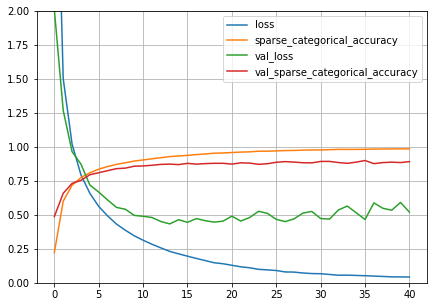

time: 281 ms (started: 2023-02-18 22:12:56 +00:00)


In [17]:
plot_loss(history)

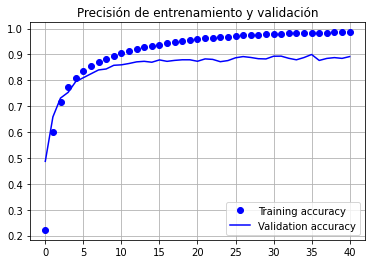

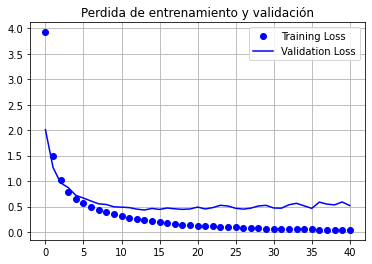

time: 450 ms (started: 2023-02-18 22:12:57 +00:00)


In [18]:
show_history(history)

In [19]:
save_model(SIZE, TFM_PATH, custom_model, TYPE_IMG, USE_DATA_AUG, DNN_NAME, FC_LAYER)

------ Model Saved in /content/gdrive/MyDrive/Master_IA/TFM/notebooks/arqs_2023/VGG19/weights_vgg19/sin_DA/regular/4096/model_vgg19_etl8_imgs96_regular.h5-------
time: 1.86 s (started: 2023-02-18 22:12:57 +00:00)


# Imgs 112x112

- Test Accuracy: 0.8917794823646545
- Test Loss: 0.46061280369758606
- time: 12min 20s
- F1 score: 0.8930144129349363
- Precision score: 0.9097477973472547
- Recall:  0.8917794698251551
- Epoch: 22/50


## Cargar imágenes

In [20]:
SIZE = 112  # integer number. Ex: 64, 96, 112 or 127
WIDTH_SHAPE = SIZE
HEIGHT_SHAPE = SIZE
PATH = ROOT_PATH.format(SIZE)

time: 550 µs (started: 2023-02-18 22:12:59 +00:00)


In [21]:
train_images, train_labels, val_images, val_labels = load_images_for_training(DATA_REPR, PATH, TYPE_IMG)

time: 18.4 s (started: 2023-02-18 22:12:59 +00:00)


In [22]:
print('- train images:', train_images.shape, 'and labels:', train_labels.shape)
print()
print('- val images:', val_images.shape, 'and labels:', val_labels.shape)
print()

- train images: (106380, 112, 112, 1) and labels: (106380,)

- val images: (21276, 112, 112, 1) and labels: (21276,)

time: 876 µs (started: 2023-02-18 22:13:17 +00:00)


## Preparar el modelo

In [23]:
vgg_updated = configure_weights_model(HEIGHT_SHAPE , WIDTH_SHAPE, CHANNEL)

time: 679 ms (started: 2023-02-18 22:13:17 +00:00)


In [24]:
custom_model = create_custom_model(NUM_CLASSES, FC_LAYER)

time: 33.6 ms (started: 2023-02-18 22:13:18 +00:00)


In [25]:
print(custom_model.summary())

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 112, 112, 1)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 112, 112, 64)      640       
                                                                 
 block1_conv2 (Conv2D)       (None, 112, 112, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 56, 56, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 56, 56, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 56, 56, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 28, 28, 128)       0   

## Entrenar modelo


In [26]:
history = train_model(custom_model, train_images, train_labels, val_images, val_labels)

Epoch 1/50
3325/3325 [==============================] - 36s 10ms/step - loss: 3.4447 - sparse_categorical_accuracy: 0.3010 - val_loss: 1.5282 - val_sparse_categorical_accuracy: 0.5974
Epoch 2/50
3325/3325 [==============================] - 33s 10ms/step - loss: 1.1181 - sparse_categorical_accuracy: 0.6937 - val_loss: 0.9484 - val_sparse_categorical_accuracy: 0.7336
Epoch 3/50
3325/3325 [==============================] - 33s 10ms/step - loss: 0.7469 - sparse_categorical_accuracy: 0.7883 - val_loss: 0.7172 - val_sparse_categorical_accuracy: 0.7957
Epoch 4/50
3325/3325 [==============================] - 33s 10ms/step - loss: 0.5738 - sparse_categorical_accuracy: 0.8341 - val_loss: 0.6358 - val_sparse_categorical_accuracy: 0.8154
Epoch 5/50
3325/3325 [==============================] - 33s 10ms/step - loss: 0.4714 - sparse_categorical_accuracy: 0.8617 - val_loss: 0.5476 - val_sparse_categorical_accuracy: 0.8407
Epoch 6/50
3325/3325 [==============================] - 33s 10ms/step - loss: 0.

In [27]:
test_images, test_labels = load_test_images(DATA_REPR, PATH, TYPE_IMG)

time: 2.48 s (started: 2023-02-18 22:25:39 +00:00)


In [28]:
show_metrics(custom_model, test_images, test_labels)

444/444 [==============================] - 3s 6ms/step
*********************************************************************************************************************************

- Test Accuracy: 0.8917794823646545
- Test Loss: 0.46061280369758606
- time:
- F1 score: 0.8930144129349363
- Precision score: 0.9097477973472547
- Recall:  0.8917794698251551
- Epoch: 
*********************************************************************************************************************************
time: 8.37 s (started: 2023-02-18 22:25:41 +00:00)


## Graficando

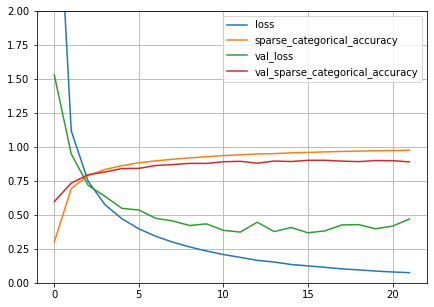

time: 191 ms (started: 2023-02-18 22:25:50 +00:00)


In [29]:
plot_loss(history)

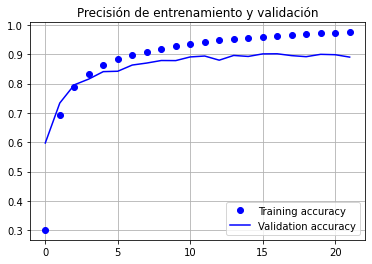

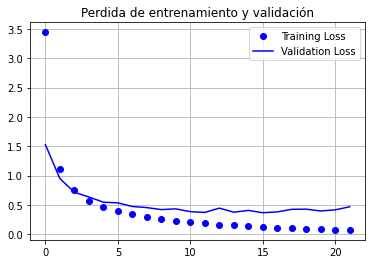

time: 384 ms (started: 2023-02-18 22:25:50 +00:00)


In [30]:
show_history(history)

In [31]:
save_model(SIZE, TFM_PATH, custom_model, TYPE_IMG, USE_DATA_AUG, DNN_NAME, FC_LAYER)

------ Model Saved in /content/gdrive/MyDrive/Master_IA/TFM/notebooks/arqs_2023/VGG19/weights_vgg19/sin_DA/regular/4096/model_vgg19_etl8_imgs112_regular.h5-------
time: 1.24 s (started: 2023-02-18 22:25:50 +00:00)


In [ ]:
runtime.unassign()

# Imgs 127x127

- Test Accuracy: 0.9082064032554626
- Test Loss: 0.43036550283432007
- time: 20min 48s
- F1 score: 0.9089223096875125
- Precision score: 0.9215671452541806
- Recall:  0.9082064297800339
- Epoch: 30/50

## Cargar imágenes

In [ ]:
SIZE = 127  # integer number. Ex: 64, 96, 112 or 127
WIDTH_SHAPE = SIZE
HEIGHT_SHAPE = SIZE
PATH = ROOT_PATH.format(SIZE)

time: 927 µs (started: 2023-02-14 16:01:29 +00:00)


In [ ]:
train_images, train_labels, val_images, val_labels = load_images_for_training(DATA_REPR, PATH, TYPE_IMG)

time: 23.6 s (started: 2023-02-14 16:01:30 +00:00)


In [ ]:
print('- train images:', train_images.shape, 'and labels:', train_labels.shape)
print()
print('- val images:', val_images.shape, 'and labels:', val_labels.shape)
print()

- train images: (106380, 127, 127, 1) and labels: (106380,)

- val images: (21276, 127, 127, 1) and labels: (21276,)

time: 1.07 ms (started: 2023-02-14 16:01:53 +00:00)


## Preparar el modelo

In [ ]:
vgg_updated = configure_weights_model(HEIGHT_SHAPE , WIDTH_SHAPE, CHANNEL)

time: 695 ms (started: 2023-02-14 16:01:53 +00:00)


In [ ]:
custom_model = create_custom_model(NUM_CLASSES, FC_LAYER)

time: 37.6 ms (started: 2023-02-14 16:01:54 +00:00)


In [ ]:
print(custom_model.summary())

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 127, 127, 1)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 127, 127, 64)      640       
                                                                 
 block1_conv2 (Conv2D)       (None, 127, 127, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 63, 63, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 63, 63, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 63, 63, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 31, 31, 128)       0   

## Entrenar modelo

In [ ]:
history = train_model(custom_model, train_images, train_labels, val_images, val_labels)

Epoch 1/50
3325/3325 [==============================] - 45s 13ms/step - loss: 3.3437 - sparse_categorical_accuracy: 0.3196 - val_loss: 1.4267 - val_sparse_categorical_accuracy: 0.6166
Epoch 2/50
3325/3325 [==============================] - 41s 12ms/step - loss: 1.0098 - sparse_categorical_accuracy: 0.7209 - val_loss: 0.8634 - val_sparse_categorical_accuracy: 0.7575
Epoch 3/50
3325/3325 [==============================] - 41s 12ms/step - loss: 0.6588 - sparse_categorical_accuracy: 0.8102 - val_loss: 0.6093 - val_sparse_categorical_accuracy: 0.8233
Epoch 4/50
3325/3325 [==============================] - 41s 12ms/step - loss: 0.5034 - sparse_categorical_accuracy: 0.8527 - val_loss: 0.5265 - val_sparse_categorical_accuracy: 0.8480
Epoch 5/50
3325/3325 [==============================] - 41s 12ms/step - loss: 0.4072 - sparse_categorical_accuracy: 0.8793 - val_loss: 0.4817 - val_sparse_categorical_accuracy: 0.8594
Epoch 6/50
3325/3325 [==============================] - 42s 13ms/step - loss: 0.

In [ ]:
test_images, test_labels = load_test_images(DATA_REPR, PATH, TYPE_IMG)

time: 3.1 s (started: 2023-02-14 16:22:42 +00:00)


In [ ]:
show_metrics(custom_model, test_images, test_labels)

444/444 [==============================] - 4s 8ms/step
*********************************************************************************************************************************

- Test Accuracy: 0.9082064032554626
- Test Loss: 0.43036550283432007
- time:
- F1 score: 0.9089223096875125
- Precision score: 0.9215671452541806
- Recall:  0.9082064297800339
- Epoch: 
*********************************************************************************************************************************
time: 10.4 s (started: 2023-02-14 16:22:46 +00:00)


## Graficando

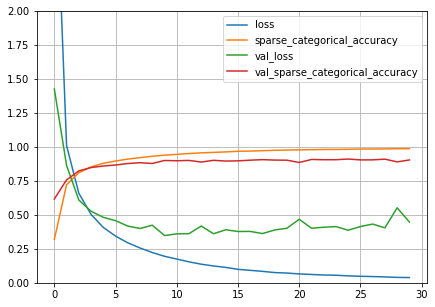

time: 207 ms (started: 2023-02-14 16:22:56 +00:00)


In [ ]:
plot_loss(history)

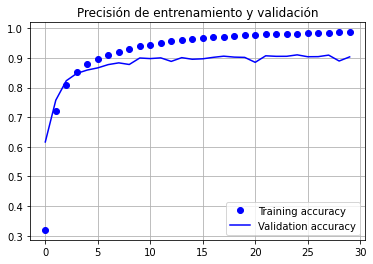

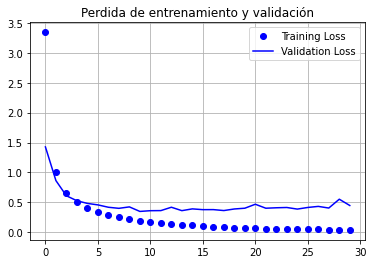

time: 404 ms (started: 2023-02-14 16:22:56 +00:00)


In [ ]:
show_history(history)

In [ ]:
save_model(SIZE, TFM_PATH, custom_model, TYPE_IMG, USE_DATA_AUG, DNN_NAME, FC_LAYER)

------ Model Saved -------
time: 2.48 s (started: 2023-02-14 16:22:57 +00:00)
